<a href="https://colab.research.google.com/github/RiccardoLeonelli2000/MLProj/blob/main/MLprog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow
!pip install scikit-learn


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline
sns.set(style="whitegrid")


**3. Synthetic Dataset Generation**

We simulate two years of daily data. Each record includes the date, sales (combining trend, seasonality, promotional effects, and holidays), and two exogenous variables (promo and holiday).

We simulate two years of daily data. Each record contains:

ds: date  
y: sales (trend + seasonality + promotion effect + holiday effect + noise)  
promo: indicator (0 or 1) for days when a promotion is active  
holiday: indicator (0 or 1) for holidays (in this example, weekends are considered "holidays").  


In [6]:
np.random.seed(42)

# Creazione dell'intervallo di date
date_range = pd.date_range(start='2022-01-01', end='2023-12-31', freq='D')
n = len(date_range)

# Variabili esogene
promo = np.random.choice([0, 1], size=n, p=[0.8, 0.2])  # probabilità 20% promo attiva
holiday = np.array([1 if d.weekday() >= 5 else 0 for d in date_range])  # weekend come festività

# Componenti per le vendite
trend = np.linspace(50, 100, n)                       # trend crescente
seasonality = 10 * np.sin(np.arange(n) * 2 * np.pi / 365)  # stagionalità annuale
promo_effect = promo * 20                             # effetto promozione
holiday_effect = holiday * (-5)                       # effetto festività (riduzione)
noise = np.random.normal(0, 5, n)                     # rumore casuale

# Calcolo delle vendite
sales = trend + seasonality + promo_effect + holiday_effect + noise

# Creazione del DataFrame
df = pd.DataFrame({
    'ds': date_range,
    'y': sales,
    'promo': promo,
    'holiday': holiday
})
df.head()


,ds,y,promo,holiday
0,2022-01-01,46.972261,0,1
1,2022-01-02,63.135798,1,1
2,2022-01-03,51.930265,0,0
3,2022-01-04,61.098962,0,0
4,2022-01-05,55.317996,0,0


**4. Data Visualization**

We graphically explore the time series of sales and the distribution of exogenous variables to better understand the dataset and identify potential patterns or anomalies.


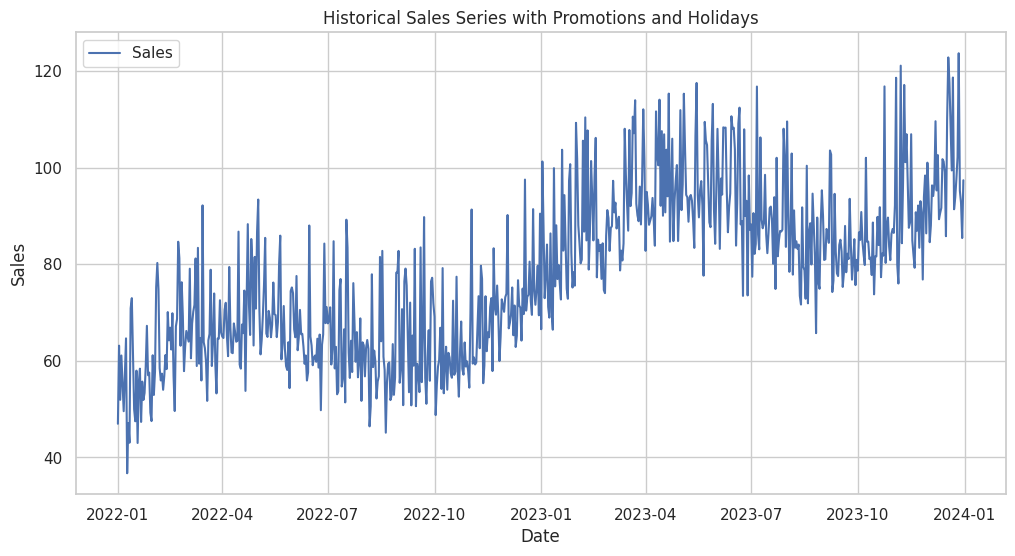

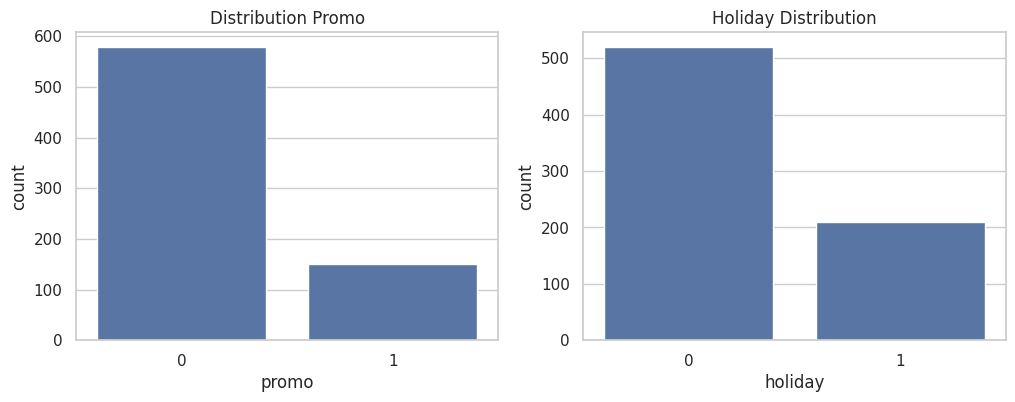

In [8]:
plt.figure(figsize=(12,6))
plt.plot(df['ds'], df['y'], label='Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Historical Sales Series with Promotions and Holidays')
plt.legend()
plt.show()

# Distribuzione delle variabili esogene
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.countplot(x='promo', data=df, ax=ax[0])
ax[0].set_title('Distribution Promo')
sns.countplot(x='holiday', data=df, ax=ax[1])
ax[1].set_title('Holiday Distribution')
plt.show()


**5. Splitting into Training and Test Sets**  

We split the dataset into training and test sets: we use data up to June 30, 2023, to train the models and the remaining data for evaluation, ensuring a valid performance assessment.



In [11]:
train = df[df['ds'] <= '2023-06-30']
test = df[df['ds'] > '2023-06-30']
print("Training set:", train.shape, "Test set:", test.shape)


Training set: (546, 4) Test set: (184, 4)


**Model 1: RandomForest with Feature Engineering (Lag Features)**  

**6.1** We implement feature engineering by creating lag features (past values) and a 7-day moving average. These new features allow the model to capture the temporal dynamics of the series.


In [12]:
def create_features(df, lags=[1,7,14]):
    df_feat = df.copy()
    for lag in lags:
        df_feat[f'lag_{lag}'] = df_feat['y'].shift(lag)
    df_feat['rolling_mean_7'] = df_feat['y'].rolling(window=7).mean()
    df_feat = df_feat.dropna().reset_index(drop=True)
    return df_feat

df_features = create_features(df)
df_features.head()


,ds,y,promo,holiday,lag_1,lag_7,lag_14,rolling_mean_7
0,2022-01-15,49.981584,0,1,61.493034,64.641813,46.972261,54.602229
1,2022-01-16,47.486837,0,1,49.981584,36.730862,63.135798,56.138797
2,2022-01-17,57.964003,0,0,47.486837,47.119941,51.930265,57.687949
3,2022-01-18,42.995129,0,0,57.964003,43.044843,61.098962,57.680847
4,2022-01-19,55.461853,0,0,42.995129,70.879158,55.317996,55.478375


**6.2 Splitting into Training and Test Sets for RandomForest**  

We select the engineered features (including promo and holiday indicators) and split the dataset into training and test sets for the RandomForest model.


In [13]:
train_rf = df_features[df_features['ds'] <= '2023-06-30']
test_rf = df_features[df_features['ds'] > '2023-06-30']

# Selezione delle feature
feature_cols = ['promo', 'holiday', 'lag_1', 'lag_7', 'lag_14', 'rolling_mean_7']
X_train = train_rf[feature_cols]
y_train = train_rf['y']
X_test = test_rf[feature_cols]
y_test = test_rf['y']


**6.3 Training and Evaluation of RandomForest**  

We train a RandomForest model using the engineered features and evaluate its performance using RMSE and MAE. We also visualize the predictions compared to the actual data.


RandomForest -> RMSE: 6.1881480652546585 MAE: 4.993414403563378


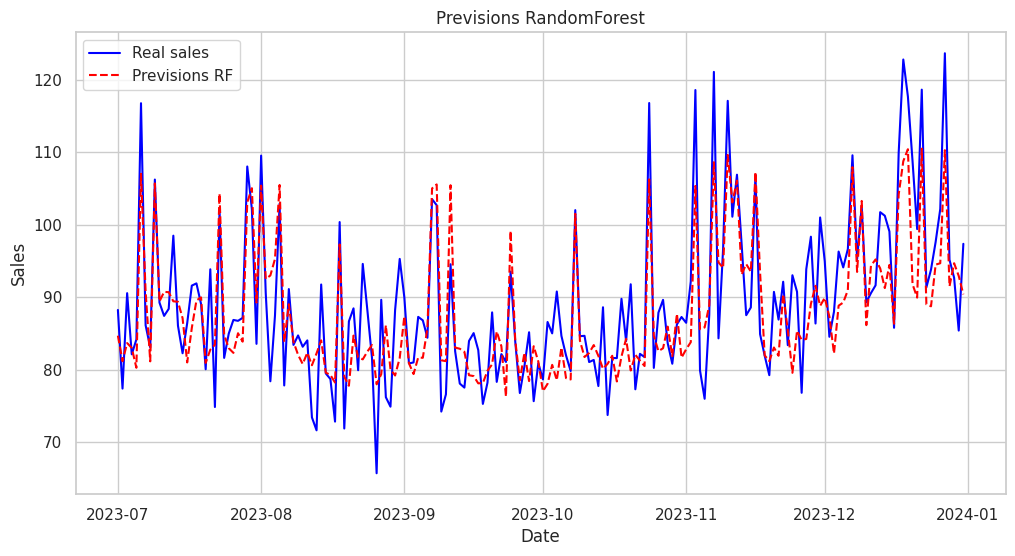

In [14]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Previsione
pred_rf = rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))
mae_rf = mean_absolute_error(y_test, pred_rf)
print("RandomForest -> RMSE:", rmse_rf, "MAE:", mae_rf)

# Visualizzazione delle previsioni
plt.figure(figsize=(12,6))
plt.plot(test_rf['ds'], y_test, label='Real sales', color='blue')
plt.plot(test_rf['ds'], pred_rf, label='Previsions RF', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Previsions RandomForest')
plt.legend()
plt.show()


**Model 2: LSTM for Forecasting**  

**7.1** We prepare the data for the LSTM model by normalizing the sales series and creating sequences using a sliding window. These sequences serve as the ideal input for a neural network that learns from temporal patterns.


In [19]:
def create_sequences(data, window_size=14):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Normalizziamo i dati (utilizziamo la colonna 'y')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(df[['y']])

# Creiamo le sequenze
window_size = 14
X_all, y_all = create_sequences(sales_scaled, window_size)
print("Shape X_all:", X_all.shape, "Shape y_all:", y_all.shape)

# Determiniamo l'indice di split in base alla data
split_date = '2023-06-30'
split_index = df[df['ds'] <= split_date].shape[0] - window_size
X_train_lstm = X_all[:split_index]
y_train_lstm = y_all[:split_index]
X_test_lstm = X_all[split_index:]
y_test_lstm = y_all[split_index:]
print("Training LSTM:", X_train_lstm.shape, y_train_lstm.shape, "Test LSTM:", X_test_lstm.shape, y_test_lstm.shape)


Shape X_all: (716, 14, 1) Shape y_all: (716, 1)
Training LSTM: (532, 14, 1) (532, 1) Test LSTM: (184, 14, 1) (184, 1)


**7.2 Creation and Training of the LSTM Model**  

We build the LSTM model with an LSTM layer followed by a dense layer. We use Early Stopping to monitor validation and prevent overfitting during training.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


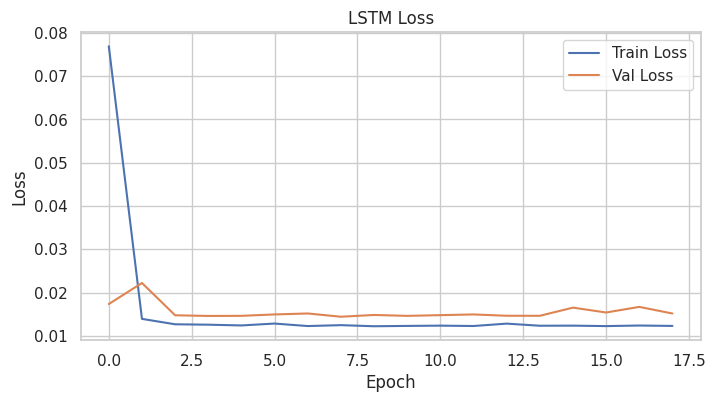

In [17]:
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')

# Early stopping per evitare overfitting
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_lstm.fit(X_train_lstm, y_train_lstm,
                         epochs=100, batch_size=16,
                         validation_split=0.2, callbacks=[es], verbose=0)

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


**7.3 LSTM Prediction and Evaluation**  

We make predictions with the LSTM model, reverse the normalization to restore values to their original scale, and calculate RMSE and MAE to assess performance. Finally, we visualize the comparison between actual sales and predictions.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
LSTM -> RMSE: 10.172881191224567 MAE: 7.542011842363295


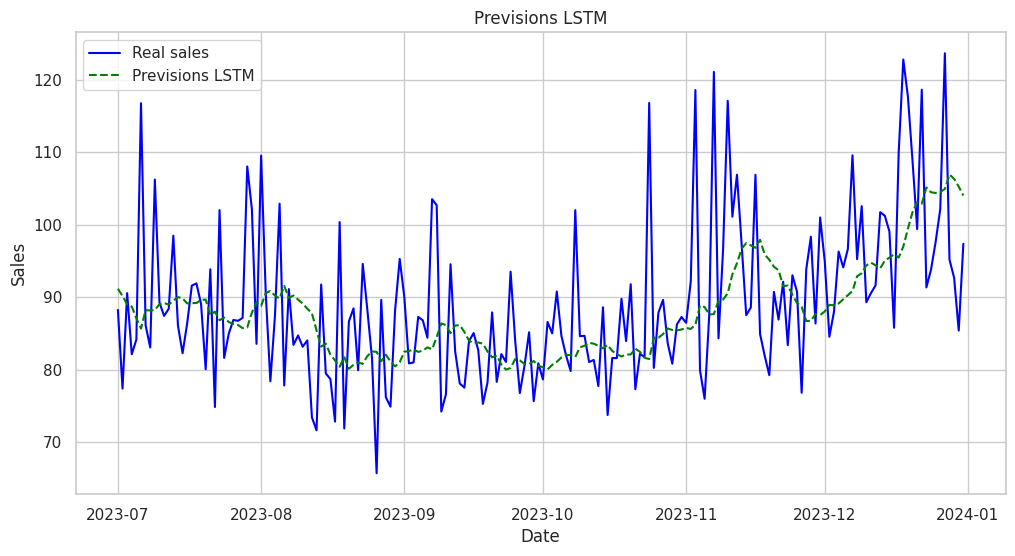

In [18]:
pred_lstm = model_lstm.predict(X_test_lstm)
# Invertiamo la normalizzazione
pred_lstm_inv = scaler.inverse_transform(pred_lstm)
y_test_lstm_inv = scaler.inverse_transform(y_test_lstm)

rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm_inv, pred_lstm_inv))
mae_lstm = mean_absolute_error(y_test_lstm_inv, pred_lstm_inv)
print("LSTM -> RMSE:", rmse_lstm, "MAE:", mae_lstm)

# Visualizzazione dei risultati LSTM
test_dates = df['ds'].iloc[-len(y_test_lstm_inv):]
plt.figure(figsize=(12,6))
plt.plot(test_dates, y_test_lstm_inv, label='Real sales', color='blue')
plt.plot(test_dates, pred_lstm_inv, label='Previsions LSTM', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Previsions LSTM')
plt.legend()
plt.show()


**Model Comparison**  

We compare the performance of the two models (RandomForest and LSTM) using RMSE and MAE metrics to highlight the model with the best predictive performance.


In [13]:
print("RandomForest -> RMSE: {:.2f}, MAE: {:.2f}".format(rmse_rf, mae_rf))
print("LSTM -> RMSE: {:.2f}, MAE: {:.2f}".format(rmse_lstm, mae_lstm))


RandomForest -> RMSE: 6.19, MAE: 4.99
LSTM -> RMSE: 10.07, MAE: 7.51
